# RelBench Arxiv Dataset - XGB - GNN
We use the RelBench arxiv dataset [here][1]. We build a graph using authors as nodes with coauthorship as edges. We define binary classification targets are "Did author publish in 2022?". We build graph and features from information before 2022.

Next we will train an XGB. And in a second notebook we train a GNN to improve the XGB.

[1]: https://relbench.stanford.edu/datasets/rel-arxiv/

# Load and Convert RelBench Arxiv Data
We load RelBench Arxiv data. Then we do EDA to determine what is a good date as a cutoff between future and past. EDA determines that using Jan 1, 2022 for target cutoff is best.

In [1]:
import os
os.environ["RELBENCH_CACHE_DIR"] = "~/rel-arxiv/"

VER=2

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [3]:
from relbench.datasets import get_dataset
dataset = get_dataset("rel-arxiv")

100%|████████████████████████████████████████| 152M/152M [00:00<00:00, 214GB/s]
Unzipping contents of '/home/cbrissette/rel-arxiv/rel-arxiv/db.zip' to '/home/cbrissette/rel-arxiv/rel-arxiv/.'


In [4]:
db = dataset.get_db()

Making Database object from scratch...
(You can also use `get_dataset(..., download=True)` for datasets prepared by the RelBench team.)


100%|████████████████████████████████████████| 114M/114M [00:00<00:00, 200GB/s]
Unzipping contents of '/home/cbrissette/.cache/pooch/a3041599408af149b3ac8120402c9553-db.zip' to '/home/cbrissette/.cache/pooch/a3041599408af149b3ac8120402c9553-db.zip.unzip'


Final dataset directory: /home/cbrissette/.cache/pooch/a3041599408af149b3ac8120402c9553-db.zip.unzip
Done in 7.29 seconds.
Caching Database object to ~/rel-arxiv//rel-arxiv/db...
Done in 1.18 seconds.


In [5]:
db.table_dict.keys()

dict_keys(['papers', 'categories', 'citations', 'paperCategories', 'authors', 'paperAuthors'])

In [6]:
dfs = []
for name, tbl in db.table_dict.items():
    df = tbl.df
    print(f"\n=== {name} ===")
    print(df.shape)
    display(df.head())
    dfs.append(df)


=== papers ===
(193696, 7)


,Paper_ID,arXiv_Code,Title,Abstract,Submission_Date,DOI,Primary_Category_ID
0,0,arXiv:1801.01549,Moving unstable particles and special relativity,In Poincare-Wigner-Dirac theory of relativisti...,2018-01-01,10.1155/2018/4657079,0
1,1,arXiv:1801.00403,Exact eigenfunction amplitude distributions of...,The exact probability distributions of the amp...,2018-01-01,10.1063/1.5006320,7
2,2,arXiv:1801.00401,Floquet engineering of multi-orbital Mott insu...,We consider driving multi-orbital Mott insulat...,2018-01-01,10.1103/PhysRevLett.121.107201,13
3,3,arXiv:1801.00395,Factorization of Standard Model cross sections...,The factorization theorem for organizing multi...,2018-01-01,10.1103/PhysRevD.97.053006,6
4,4,arXiv:1712.08944,The independence of neutral and ionized gas ou...,Using a large sample of emission line galaxies...,2018-01-01,10.3847/1538-4357/aaa42d,16



=== categories ===
(53, 2)


,Category_ID,Category
0,0,42
1,1,10
2,2,52
3,3,16
4,4,17



=== citations ===
(1223361, 3)


,Paper_ID,References_Paper_ID,Submission_Date
0,27,16096,2018-01-01
1,37,16955,2018-01-01
2,40,153595,2018-01-01
3,3,1715,2018-01-01
4,8,71985,2018-01-01



=== paperCategories ===
(133060, 3)


,Paper_ID,Category_ID,Submission_Date
0,26,22,2018-01-01
1,26,34,2018-01-01
2,28,1,2018-01-01
3,29,23,2018-01-01
4,30,23,2018-01-01



=== authors ===
(143691, 3)


,Author_ID,Name,ORCID
0,0,Stefanovich Eugene V.,http://orcid.org/0000-0002-8973-7804
1,1,Fonin Mikhail,http://orcid.org/0000-0003-3015-0045
2,2,Wietstruk Marko,http://orcid.org/0000-0002-1949-283X
3,3,Böttcher Stefan,http://orcid.org/0000-0002-1058-8480
4,4,Koch Roland J.,http://orcid.org/0000-0001-5748-8463



=== paperAuthors ===
(452251, 3)


,Paper_ID,Author_ID,Submission_Date
0,0,0,2018-01-01
1,35,1,2018-01-01
2,35,2,2018-01-01
3,35,3,2018-01-01
4,35,4,2018-01-01


# EDA Paper Submission Dates

In [7]:
papers_df = db.table_dict["papers"].df.copy()
papers_df["Submission_Date"] = pd.to_datetime(papers_df["Submission_Date"])
print("Min and Max Date:")
papers_df["Submission_Date"].min(), papers_df["Submission_Date"].max()

Min and Max Date:


(Timestamp('2018-01-01 00:00:00'), Timestamp('2023-01-01 00:00:00'))

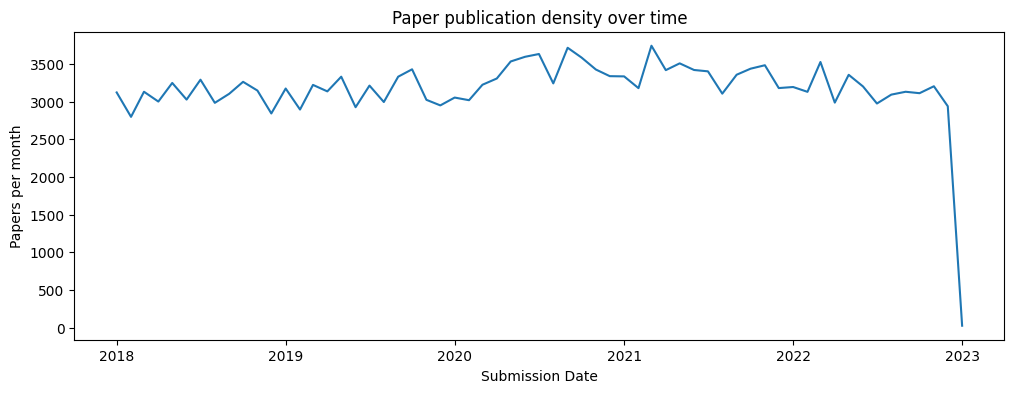

In [8]:
date_counts = (
    papers_df
    .groupby(papers_df["Submission_Date"].dt.to_period("M"))
    .size()
    .reset_index(name="n_papers")
)
date_counts["Submission_Date"] = date_counts["Submission_Date"].dt.to_timestamp()

plt.figure(figsize=(12, 4))
plt.plot(date_counts["Submission_Date"], date_counts["n_papers"])
plt.xlabel("Submission Date")
plt.ylabel("Papers per month")
plt.title("Paper publication density over time")
plt.show()

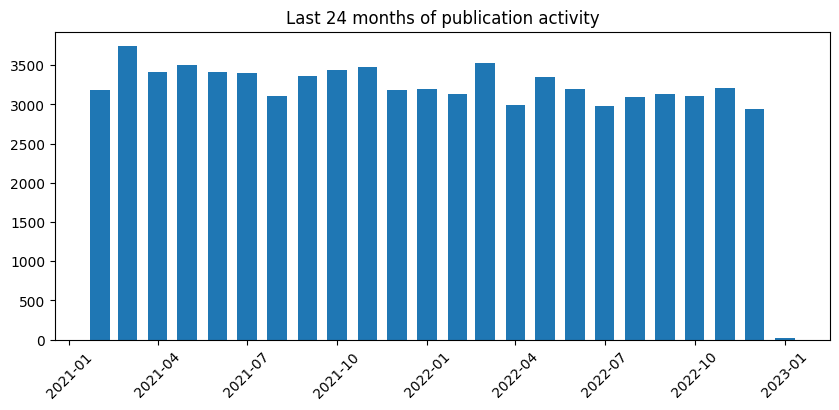

In [9]:
tail = date_counts.tail(24)  # last 2 years

plt.figure(figsize=(10, 4))
plt.bar(tail["Submission_Date"], tail["n_papers"], width=20)
plt.xticks(rotation=45)
plt.title("Last 24 months of publication activity")
plt.show()

In [10]:
T = pd.Timestamp("2022-01-01")

future = papers_df[
    (papers_df["Submission_Date"] > T) &
    (papers_df["Submission_Date"] <= T + pd.DateOffset(years=1))
]
print("Papers submitted in 2022:")
future.shape

Papers submitted in 2022:


(37851, 7)

# Create Author Targets (After Jan 1, 2022)
We define target as "Did author published paper in 2022?"

In [11]:
T = pd.Timestamp("2022-01-01")
T_end = T + pd.DateOffset(years=1)

authors_df = db.table_dict["authors"].df.copy()
paper_authors_df = db.table_dict["paperAuthors"].df.copy()
paper_authors_df["Submission_Date"] = pd.to_datetime(
    paper_authors_df["Submission_Date"]
)

future_authors = (
    paper_authors_df.loc[
        (paper_authors_df["Submission_Date"] > T) &
        (paper_authors_df["Submission_Date"] <= T_end),
        "Author_ID"
    ]
    .drop_duplicates()
)

author_targets = (
    authors_df[["Author_ID"]]
    .assign(
        target=lambda df: df["Author_ID"].isin(future_authors).astype("int8")
    )
)

author_targets.head()

,Author_ID,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1


In [12]:
print("Target counts distribution:")
author_targets["target"].value_counts(normalize=True)

Target counts distribution:


target
0    0.561754
1    0.438246
Name: proportion, dtype: float64

# Create Author (as Nodes) Graph (Before Jan 1, 2022)
Find author edges based on co-author info before 2022

In [13]:
from itertools import combinations
from collections import Counter, defaultdict

T = pd.Timestamp("2022-01-01")

paper_authors = db.table_dict["paperAuthors"].df.copy()
paper_authors["Submission_Date"] = pd.to_datetime(paper_authors["Submission_Date"])

paper_authors_hist = paper_authors[
    paper_authors["Submission_Date"] < T
]

In [16]:
"""
paper_to_authors = (
    paper_authors_hist
    .groupby("Paper_ID")["Author_ID"]
    .apply(list)
)
"""
paper_groups = (
    paper_authors_hist
    .groupby("Paper_ID")
    .agg({
        "Author_ID": list,
        "Submission_Date": "first"  # Assumes one date per paper
    })
)

In [17]:
%%time

coauthor_counter = defaultdict(Counter)
coauthor_last_date = defaultdict(dict)

for row in paper_groups.itertuples():
    authors = row.Author_ID
    p_date = row.Submission_Date
    
    # Need at least 2 authors to form an edge
    if len(authors) < 2:
        continue
    
    # Generate all pairs (edges) for this paper
    for a, b in combinations(authors, 2):
        # 1. Update Weights (Counts)
        coauthor_counter[a][b] += 1
        coauthor_counter[b][a] += 1
        
        # 2. Update Weights (Most Recent Timestamp)
        # Check existing date for a->b, update if current paper is newer
        curr_a = coauthor_last_date[a].get(b, pd.Timestamp.min)
        if p_date > curr_a:
            coauthor_last_date[a][b] = p_date
            
        # Check existing date for b->a, update if current paper is newer
        curr_b = coauthor_last_date[b].get(a, pd.Timestamp.min)
        if p_date > curr_b:
            coauthor_last_date[b][a] = p_date

print("Graph construction complete.")

Graph construction complete.
CPU times: user 2min 15s, sys: 57 ms, total: 2min 15s
Wall time: 2min 15s


In [21]:
"""
def extract_coauthors(author_id):
    counter = coauthor_counter.get(author_id, {})
    if not counter:
        return [], []
    ids = [int(k) for k in counter.keys()]
    counts = [int(v) for v in counter.values()]

    return ids, counts
"""
def extract_coauthors(author_id):
    counter = coauthor_counter.get(author_id, {})
    date_tracker = coauthor_last_date.get(author_id, {})
    
    if not counter:
        return [], [], []
    
    # Get IDs
    ids = [int(k) for k in counter.keys()]
    
    # Get corresponding Counts (Weights)
    counts = [int(counter[k]) for k in ids]
    
    # Get corresponding Max Timestamps (New Weights)
    # Return as numeric timestamp or datetime object depending on preference
    # Here we return the datetime object
    dates = [(T - date_tracker[k]).days for k in ids]

    return ids, counts, dates

In [23]:
%%time 

coauthor_data = author_targets["Author_ID"].apply(extract_coauthors)

author_targets["coauthor_ids"] = coauthor_data.apply(lambda x: x[0])
author_targets["coauthor_counts"] = coauthor_data.apply(lambda x: x[1])
author_targets["coauthor_time_delta"] = coauthor_data.apply(lambda x: x[2])

author_targets.head()

CPU times: user 17.4 s, sys: 163 ms, total: 17.5 s
Wall time: 17.3 s


,Author_ID,target,coauthor_ids,coauthor_counts,coauthor_dates,coauthor_time_delta
0,0,0,[],[],[],[]
1,1,0,"[2, 3, 4, 5, 6, 7, 8]","[1, 1, 1, 1, 1, 1, 1]","[1461, 1461, 1461, 1461, 1461, 1461, 1461]","[1461, 1461, 1461, 1461, 1461, 1461, 1461]"
2,2,0,"[1, 3, 4, 5, 6, 7, 8]","[1, 1, 1, 1, 1, 1, 1]","[1461, 1461, 1461, 1461, 1461, 1461, 1461]","[1461, 1461, 1461, 1461, 1461, 1461, 1461]"
3,3,0,"[1, 2, 4, 5, 6, 7, 8]","[1, 1, 1, 1, 1, 1, 1]","[1461, 1461, 1461, 1461, 1461, 1461, 1461]","[1461, 1461, 1461, 1461, 1461, 1461, 1461]"
4,4,1,"[1, 2, 3, 5, 6, 7, 8, 2905, 2819, 2906, 2907, ...","[1, 1, 1, 4, 4, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, ...","[1461, 1461, 1461, 761, 761, 1461, 1461, 1013,...","[1461, 1461, 1461, 761, 761, 1461, 1461, 1013,..."


In [24]:
print("Percentage authors without co-authors:")
(author_targets["coauthor_ids"].str.len() == 0).mean()

Percentage authors without co-authors:


0.35958410756414805

# Graph EDA

In [25]:
author_targets["degree"] = author_targets["coauthor_ids"].apply(len)

deg = author_targets["degree"]

stats = {
    "num_authors": len(deg),
    "fraction_isolated": (deg == 0).mean(),
    "mean_degree": deg.mean(),
    "median_degree": deg.median(),
    "max_degree": deg.max(),
}

stats

{'num_authors': 143691,
 'fraction_isolated': 0.35958410756414805,
 'mean_degree': 77.82060115108114,
 'median_degree': 2.0,
 'max_degree': 3768}

In [26]:
deg_pos = deg[deg > 0]
{
    "mean_degree_nonzero": deg_pos.mean(),
    "median_degree_nonzero": deg_pos.median(),
}

{'mean_degree_nonzero': 121.51572450066288, 'median_degree_nonzero': 5.0}

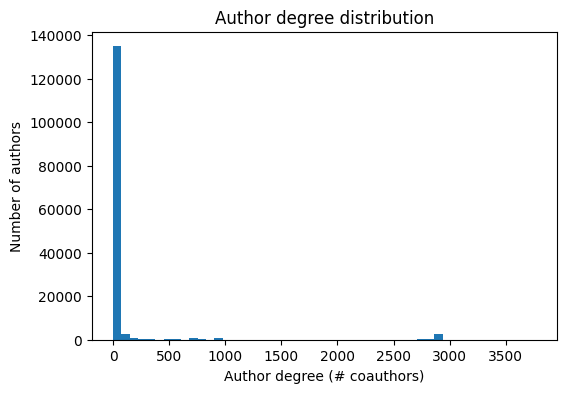

In [27]:
plt.figure(figsize=(6, 4))
plt.hist(deg, bins=50)
plt.xlabel("Author degree (# coauthors)")
plt.ylabel("Number of authors")
plt.title("Author degree distribution")
plt.show()

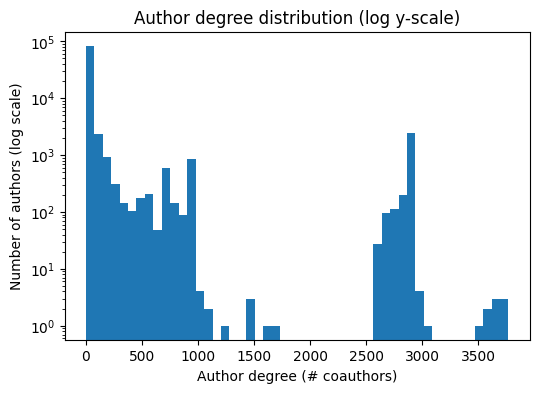

In [28]:
plt.figure(figsize=(6, 4))
plt.hist(deg[deg > 0], bins=50)
plt.yscale("log")
plt.xlabel("Author degree (# coauthors)")
plt.ylabel("Number of authors (log scale)")
plt.title("Author degree distribution (log y-scale)")
plt.show()

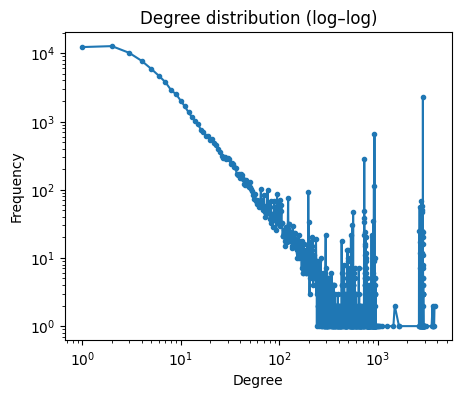

In [29]:
counts = deg.value_counts().sort_index()
counts = counts[counts.index > 0]

plt.figure(figsize=(5, 4))
plt.plot(counts.index, counts.values, marker=".")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree distribution (log–log)")
plt.show()

In [30]:
all_edge_weights = np.concatenate(
    author_targets["coauthor_counts"].values
)
pd.Series(all_edge_weights).describe()

count    1.118212e+07
mean     5.588486e+00
std      2.976902e+00
min      1.000000e+00
25%      2.000000e+00
50%      8.000000e+00
75%      8.000000e+00
max      1.610000e+02
dtype: float64

In [31]:
print("Repeat collaborations 2:")
print( (pd.Series(all_edge_weights) >= 2).mean() )   
print("Repeat collaborations 5:")
print( (pd.Series(all_edge_weights) >= 5).mean() )

Repeat collaborations 2:
0.8070042174471388
Repeat collaborations 5:
0.6421919993704235


# Feature Engineer - Author (Node) Features

# Feature Engineer about Co-author Stats and Paper Publish Stats

In [32]:
def entropy(counts):
    if len(counts) == 0:
        return 0.0
    p = np.array(counts, dtype=float)
    p = p / p.sum()
    return -(p * np.log(p + 1e-12)).sum()

In [33]:
author_feats = author_targets[["Author_ID"]].copy()

author_feats["n_coauthors"] = author_targets["coauthor_ids"].apply(len)

author_feats["total_collaborations"] = author_targets["coauthor_counts"].apply(
    lambda x: int(np.sum(x)) if len(x) else 0
)

author_feats["avg_collab_strength"] = author_targets["coauthor_counts"].apply(
    lambda x: float(np.mean(x)) if len(x) else 0.0
)

author_feats["max_collab_strength"] = author_targets["coauthor_counts"].apply(
    lambda x: int(np.max(x)) if len(x) else 0
)

author_feats["collab_entropy"] = author_targets["coauthor_counts"].apply(entropy)

In [34]:
paper_authors = db.table_dict["paperAuthors"].df.copy()
papers = db.table_dict["papers"].df.copy()

paper_authors["Submission_Date"] = pd.to_datetime(paper_authors["Submission_Date"])
papers["Submission_Date"] = pd.to_datetime(papers["Submission_Date"])

paper_authors_hist = paper_authors[paper_authors["Submission_Date"] < T]
papers_hist = papers[papers["Submission_Date"] < T]

In [35]:
total_papers = (
    paper_authors_hist
    .groupby("Author_ID")
    .size()
    .rename("total_papers")
)

In [36]:
papers_last_1y = (
    paper_authors_hist[
        paper_authors_hist["Submission_Date"] >= (T - pd.DateOffset(years=1))
    ]
    .groupby("Author_ID")
    .size()
    .rename("papers_last_1y")
)

In [37]:
papers_last_3y = (
    paper_authors_hist[
        paper_authors_hist["Submission_Date"] >= (T - pd.DateOffset(years=3))
    ]
    .groupby("Author_ID")
    .size()
    .rename("papers_last_3y")
)

In [39]:
last_pub_date = (
    paper_authors_hist
    .groupby("Author_ID")["Submission_Date"]
    .max()
)

time_since_last_paper = (
    (T - last_pub_date).dt.days
    .rename("days_since_last_paper")
)

In [40]:
author_feats = (
    author_feats
    .merge(total_papers, on="Author_ID", how="left")
    .merge(papers_last_1y, on="Author_ID", how="left")
    .merge(papers_last_3y, on="Author_ID", how="left")
    .merge(time_since_last_paper, on="Author_ID", how="left")
)

author_feats.fillna({
    "total_papers": 0,
    "papers_last_1y": 0,
    "papers_last_3y": 0,
    "days_since_last_paper": 10_000,  # effectively "never"
}, inplace=True)

In [41]:
author_features = (
    author_targets[["Author_ID", "target"]]
    .merge(author_feats, on="Author_ID", how="left")
)

In [42]:
author_features.head()

,Author_ID,target,n_coauthors,total_collaborations,avg_collab_strength,max_collab_strength,collab_entropy,total_papers,papers_last_1y,papers_last_3y,days_since_last_paper
0,0,0,0,0,0.000000,0,0.000000,1.0,0.0,0.0,1461.0
1,1,0,7,7,1.000000,1,1.945910,1.0,0.0,0.0,1461.0
2,2,0,7,7,1.000000,1,1.945910,1.0,0.0,0.0,1461.0
3,3,0,7,7,1.000000,1,1.945910,1.0,0.0,0.0,1461.0
4,4,1,38,48,1.263158,4,3.524627,6.0,0.0,4.0,408.0


In [43]:
author_features.describe()

,Author_ID,target,n_coauthors,total_collaborations,avg_collab_strength,max_collab_strength,collab_entropy,total_papers,papers_last_1y,papers_last_3y,days_since_last_paper
count,143691.0,143691.000000,143691.000000,143691.000000,143691.000000,143691.000000,1.436910e+05,143691.000000,143691.000000,143691.000000,143691.000000
mean,71845.0,0.438246,77.820601,434.899333,0.908073,1.439520,1.261695e+00,2.255270,0.897467,1.972149,3174.906744
std,41480.163102,0.496174,409.473738,2837.046410,1.134751,2.570548,1.693149e+00,4.255973,1.772844,3.617363,4376.644155
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000089e-12,0.000000,0.000000,0.000000,1.000000
25%,35922.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,163.000000
50%,71845.0,0.000000,2.000000,2.000000,1.000000,1.000000,6.931472e-01,1.000000,0.000000,1.000000,493.000000
75%,107767.5,1.000000,7.000000,8.000000,1.052632,2.000000,1.945910e+00,2.000000,1.000000,2.000000,10000.000000
max,143690.0,1.000000,3768.000000,22970.000000,10.617021,161.000000,8.179091e+00,355.000000,126.000000,307.000000,10000.000000


# Feature Engineer about Paper Topic

In [44]:
paper_categories = db.table_dict["paperCategories"].df.copy()
paper_categories["Submission_Date"] = pd.to_datetime(paper_categories["Submission_Date"])

paper_categories_hist = paper_categories[paper_categories["Submission_Date"] < T]

# Join author ↔ paper ↔ category
author_paper_cat = (
    paper_authors_hist
    .merge(paper_categories_hist[["Paper_ID", "Category_ID"]],
           on="Paper_ID",
           how="left")
)

In [45]:
author_cat_counts = (
    author_paper_cat
    .groupby(["Author_ID", "Category_ID"])
    .size()
    .rename("n_papers_cat")
    .reset_index()
)

In [46]:
top_cat = (
    author_cat_counts
    .sort_values(["Author_ID", "n_papers_cat"], ascending=[True, False])
    .groupby("Author_ID")
    .first()
    .rename(columns={
        "Category_ID": "top_category",
        "n_papers_cat": "top_category_papers"
    })
)

In [47]:
total_cat_papers = (
    author_cat_counts
    .groupby("Author_ID")["n_papers_cat"]
    .sum()
    .rename("total_category_papers")
)

In [48]:
category_dominance = (
    top_cat["top_category_papers"] / total_cat_papers
).rename("top_category_frac")

In [49]:
def cat_entropy(x):
    p = x / x.sum()
    return -(p * np.log(p + 1e-12)).sum()

category_entropy = (
    author_cat_counts
    .groupby("Author_ID")["n_papers_cat"]
    .apply(cat_entropy)
    .rename("category_entropy")
)

In [50]:
author_features = (
    author_features
    .merge(top_cat[["top_category"]], on="Author_ID", how="left")
    .merge(category_dominance, on="Author_ID", how="left")
    .merge(category_entropy, on="Author_ID", how="left")
)

author_features.fillna({
    "top_category": -1,
    "top_category_frac": 0.0,
    "category_entropy": 0.0,
}, inplace=True)

In [51]:
author_features.head()

,Author_ID,target,n_coauthors,total_collaborations,avg_collab_strength,max_collab_strength,collab_entropy,total_papers,papers_last_1y,papers_last_3y,days_since_last_paper,top_category,top_category_frac,category_entropy
0,0,0,0,0,0.000000,0,0.000000,1.0,0.0,0.0,1461.0,-1,0.0,0.0
1,1,0,7,7,1.000000,1,1.945910,1.0,0.0,0.0,1461.0,-1,0.0,0.0
2,2,0,7,7,1.000000,1,1.945910,1.0,0.0,0.0,1461.0,-1,0.0,0.0
3,3,0,7,7,1.000000,1,1.945910,1.0,0.0,0.0,1461.0,-1,0.0,0.0
4,4,1,38,48,1.263158,4,3.524627,6.0,0.0,4.0,408.0,-1,0.0,0.0


# Feature Engineer about Citations

In [52]:
citations = db.table_dict["citations"].df.copy()
citations["Submission_Date"] = pd.to_datetime(citations["Submission_Date"])

citations_hist = citations[citations["Submission_Date"] < T]

# cited paper → citing paper
paper_citation_counts = (
    citations_hist
    .groupby("References_Paper_ID")
    .size()
    .rename("n_citations")
)

In [53]:
author_citations = (
    paper_authors_hist
    .merge(paper_citation_counts,
           left_on="Paper_ID",
           right_index=True,
           how="left")
)

author_citations["n_citations"] = author_citations["n_citations"].fillna(0)

In [54]:
total_citations = (
    author_citations
    .groupby("Author_ID")["n_citations"]
    .sum()
    .rename("total_citations")
)

avg_citations = (
    author_citations
    .groupby("Author_ID")["n_citations"]
    .mean()
    .rename("avg_citations_per_paper")
)

max_citations = (
    author_citations
    .groupby("Author_ID")["n_citations"]
    .max()
    .rename("max_citations_single_paper")
)

In [55]:
recent_papers = paper_authors_hist[
    paper_authors_hist["Submission_Date"] >= (T - pd.DateOffset(years=3))
]

recent_citations = (
    recent_papers
    .merge(paper_citation_counts,
           left_on="Paper_ID",
           right_index=True,
           how="left")
)

recent_citations["n_citations"] = recent_citations["n_citations"].fillna(0)

recent_citation_sum = (
    recent_citations
    .groupby("Author_ID")["n_citations"]
    .sum()
    .rename("citations_last_3y")
)

In [56]:
author_features = (
    author_features
    .merge(total_citations, on="Author_ID", how="left")
    .merge(avg_citations, on="Author_ID", how="left")
    .merge(max_citations, on="Author_ID", how="left")
    .merge(recent_citation_sum, on="Author_ID", how="left")
)

author_features.fillna({
    "total_citations": 0,
    "avg_citations_per_paper": 0.0,
    "max_citations_single_paper": 0,
    "citations_last_3y": 0,
}, inplace=True)

In [57]:
author_features.head()

,Author_ID,target,n_coauthors,total_collaborations,avg_collab_strength,max_collab_strength,collab_entropy,total_papers,papers_last_1y,papers_last_3y,days_since_last_paper,top_category,top_category_frac,category_entropy,total_citations,avg_citations_per_paper,max_citations_single_paper,citations_last_3y
0,0,0,0,0,0.000000,0,0.000000,1.0,0.0,0.0,1461.0,-1,0.0,0.0,0.0,0.000000,0.0,0.0
1,1,0,7,7,1.000000,1,1.945910,1.0,0.0,0.0,1461.0,-1,0.0,0.0,3.0,3.000000,3.0,0.0
2,2,0,7,7,1.000000,1,1.945910,1.0,0.0,0.0,1461.0,-1,0.0,0.0,3.0,3.000000,3.0,0.0
3,3,0,7,7,1.000000,1,1.945910,1.0,0.0,0.0,1461.0,-1,0.0,0.0,3.0,3.000000,3.0,0.0
4,4,1,38,48,1.263158,4,3.524627,6.0,0.0,4.0,408.0,-1,0.0,0.0,47.0,7.833333,16.0,28.0


# Simple XGB baseline
Train a basic XGB model to determine if we can predict target better than guessing using author (node) features.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
print(f"XGB version: {xgb.__version__}")

In [52]:
TARGET = "target"

FEATURES = [
    # --------------------
    # Collaboration graph
    # --------------------
    "n_coauthors",
    "total_collaborations",
    "avg_collab_strength",
    "max_collab_strength",
    "collab_entropy",

    # --------------------
    # Productivity / recency
    # --------------------
    "total_papers",
    "papers_last_1y",
    "papers_last_3y",
    "days_since_last_paper",

    # --------------------
    # Topic specialization
    # --------------------
    "top_category",          # categorical-as-ordinal (tree-safe)
    "top_category_frac",
    "category_entropy",

    # --------------------
    # Citation impact
    # --------------------
    "total_citations",
    "avg_citations_per_paper",
    "max_citations_single_paper",
    "citations_last_3y",
]

X = author_features[FEATURES]
y = author_features[TARGET].values

In [53]:
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.05,
    "max_depth": 6,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "n_estimators": 10_000,
    "random_state": 42,
    "early_stopping_rounds": 50,
    "device": "cuda",
}

In [54]:
N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

oof_preds = np.zeros(len(author_features))
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\n##### FOLD {fold} #####")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = xgb.XGBClassifier(**xgb_params)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )

    val_preds = model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_preds

    auc = roc_auc_score(y_val, val_preds)
    fold_scores.append(auc)

    print(f"Fold {fold} AUC: {auc:.5f}")


##### FOLD 1 #####
Fold 1 AUC: 0.75308

##### FOLD 2 #####
Fold 2 AUC: 0.75337

##### FOLD 3 #####
Fold 3 AUC: 0.75579

##### FOLD 4 #####
Fold 4 AUC: 0.75983

##### FOLD 5 #####
Fold 5 AUC: 0.75497


In [55]:
print("\n==============================")
print("Fold AUCs:", [f"{s:.5f}" for s in fold_scores])
print("Mean AUC :", np.mean(fold_scores))
print("OOF AUC  :", roc_auc_score(y, oof_preds))
print("==============================")


Fold AUCs: ['0.75308', '0.75337', '0.75579', '0.75983', '0.75497']
Mean AUC : 0.7554090224206466
OOF AUC  : 0.755080970524253


In [56]:
# SAVE XGB OOF
np.save(f"data/oof_preds_xgb_v{VER}",oof_preds)

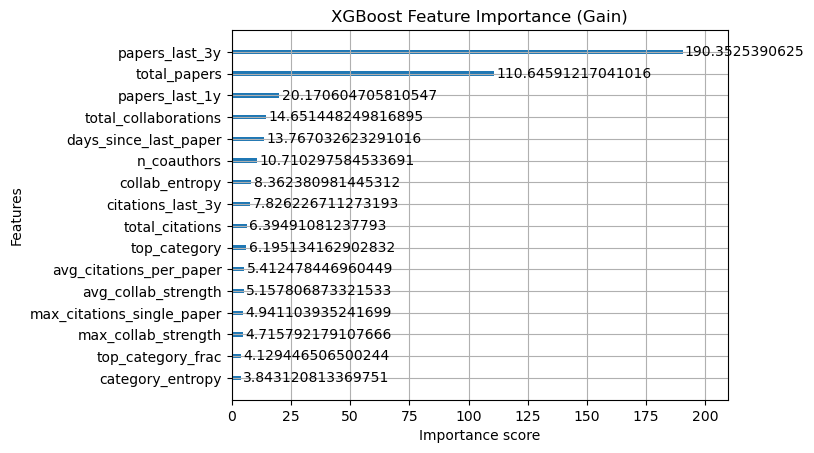

In [57]:
import matplotlib.pyplot as plt

xgb.plot_importance(
    model,
    importance_type="gain",
    max_num_features=20,
)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

# Save Data

In [59]:
author_features.to_parquet(f"data/author_features_v{VER}.pqt",index=False)
author_targets.to_parquet(f"data/author_targets_v{VER}.pqt",index=False)